In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os

# The code in this notebook should work identically between TF v1 and v2
import tensorflow as tf
import zipfile

from tensorflow.keras.applications import VGG16,ResNet50,InceptionV3, MobileNetV2
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import h5py

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 22.1MB/s 


In [0]:
#get google drive folder list
folder_list = drive.ListFile({'q': "trashed=False"}).GetList()
for folder in folder_list:
  print ('folder title: %s, id: %s' % (folder['title'], folder['id']))

folder title: 6889_project_model_mobileNet.ipynb, id: 1Ano8u92CuXRtqBNpdctV4qUAhiLTSrpb
folder title: my_model.h5, id: 1Sa2d6St8D4JcuYquPvaUBhsGmEleQF94
folder title: 6889_project, id: 1v08mdFpUSNd5cmwN1eiQK60FhBbOqju5
folder title: startercode_memory.ipynb, id: 19EtJNMyYX66aNB0G-RokSvPyboRwQr1x
folder title: “HW2_part1_2.ipynb, id: 1lHoby340TukKVyJ0kUUQgNKppWq_GyP9
folder title: 6889_project_model, id: 1uLaLYkzydZ-zyfFaGxJSY4urIKMSyGpE
folder title: ali.ipynb, id: 1kLyU2BmNTZbPpM-vI1J68twvoN9PfF7M
folder title: Model.ipynb, id: 1bZ2V4FTED5lWYheM60u84Z7uqlYHsGEn
folder title: startercode_local_disk.ipynb, id: 1IF4rPz41Zw8NUcBn3X27OSV4l0pP8_Yz
folder title: hw1_part1.ipynb, id: 1qn1kkwjiH3FWvJYOCtSKApr7BCtdkd9Q
folder title: label_091_67_75.jpg, id: 1AJTgQWkhoTxUNih5pH2t1zECjAfe13BO
folder title: label_091_60_71.jpg, id: 1HhqDhcceGOdyEcTix0QkA8UwmAoUjTjQ
folder title: label_091_80_70.jpg, id: 1Ib7AL9tb6Zza686rDudCw8gqJ0FXSw6_
folder title: label_091_61_93.jpg, id: 1Zq-RP6HgkKPXMxf1QfVFJ

In [0]:
model_folder_id = '1v08mdFpUSNd5cmwN1eiQK60FhBbOqju5'

In [0]:
! pwd

/content


In [0]:
! unzip data.zip

Archive:  data.zip
   creating: training/
  inflating: training/.DS_Store      
   creating: __MACOSX/
   creating: __MACOSX/training/
  inflating: __MACOSX/training/._.DS_Store  
   creating: training/suit_adult/
  inflating: training/suit_adult/.DS_Store  
   creating: __MACOSX/training/suit_adult/
  inflating: __MACOSX/training/suit_adult/._.DS_Store  
  inflating: training/suit_adult/1000.jpg  
  inflating: training/suit_adult/1001.jpg  
  inflating: training/suit_adult/1002.jpg  
  inflating: training/suit_adult/1003.jpg  
  inflating: training/suit_adult/1005.jpg  
  inflating: training/suit_adult/1006.jpg  
  inflating: training/suit_adult/1007.jpg  
  inflating: training/suit_adult/1009.jpg  
  inflating: training/suit_adult/1010.jpg  
  inflating: training/suit_adult/1012.jpg  
  inflating: training/suit_adult/1013.jpg  
  inflating: training/suit_adult/1014.jpg  
  inflating: training/suit_adult/1015.jpg  
  inflating: training/suit_adult/1016.jpg  
  inflating: training/suit

In [0]:
! ls training

suit_adult  suit_all  suit_none


In [0]:
#set data path
base_dir = ''
train_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir,'val')

train_adult_dir = os.path.join(train_dir, 'suit_adult')
train_none_dir = os.path.join(train_dir, 'suit_none')
train_all_dir = os.path.join(train_dir, 'suit_all')

validation_adult_dir = os.path.join(validation_dir, 'suit_adult')
validation_none_dir = os.path.join(validation_dir, 'suit_none')
validation_all_dir = os.path.join(validation_dir, 'suit_all')


In [0]:
#explore data
num_adult_tr = len(os.listdir(train_adult_dir))
num_none_tr = len(os.listdir(train_none_dir))
num_all_tr = len(os.listdir(train_all_dir))

num_adult_val = len(os.listdir(validation_adult_dir))
num_none_val = len(os.listdir(validation_none_dir))
num_all_val = len(os.listdir(validation_all_dir))

total_train = num_adult_tr + num_none_tr + num_all_tr
total_val = num_adult_val + num_none_val + num_all_val

In [0]:
print('train set:',num_adult_tr, num_none_tr, num_all_tr)
print('validation set:',num_adult_val, num_none_val, num_all_val)

print('total train set:', total_train)
print('total val set:', total_val)

train set: 3677 4849 4430
validation set: 885 975 995
total train set: 12956
total val set: 2855


In [0]:
# Images will be resized to(TARGET_SHAPE, TARGET_SHAPE) as they're read off disk.
TARGET_SHAPE = 224 
BATCH_SIZE = 32

In [0]:
#data preprocessing: only resale to 1/255 as dataset size is big engough
train_image_generator = ImageDataGenerator(rescale=1./255)
                                           #rotation_range=45, 
                                           #width_shift_range=.2,
                                           #height_shift_range=0.2,
                                           #horizontal_flip=True, 
                                           #vertical_flip=True,                                            
                                          #zoom_range=0.5,
                                          #fill_mode='reflect')
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [0]:
#read images
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE, 
                                                     directory=train_dir, 
                                                     shuffle=True, # Best practice: shuffle the training data
                                                     target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                                     class_mode='categorical')


Found 12953 images belonging to 3 classes.


In [0]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE, 
                                                              directory=validation_dir, 
                                                              target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                                              class_mode='categorical')
                                                              
        

Found 2855 images belonging to 3 classes.


In [0]:
# only need to do this part if needs data augmentation later
#--------------------------------------------------------------------
#apply augmentation to a single image from dataset for 5 times
#augmented_images=[train_data_gen[0][0][0] for i in range(5)]

In [0]:
#image examples
#next generates a batch of images
#sample_training_images, sample_training_labels = next(train_data_gen)

In [0]:

# This function will plot images in a grid with 1 row and 5 columns
# def plotImages(images_arr):
#     fig, axes = plt.subplots(1, 5, figsize=(20,20))
#     axes = axes.flatten()
#     for img, ax in zip( images_arr, axes):
#         ax.grid(False)
#         ax.imshow(img)
#     plt.tight_layout()
#     plt.show()

In [0]:
#show top 5 images
#plotImages(augmented_images)
#----------------------------------------------------------------

In [0]:
#Use mobile net, skip this part
#-----------------------------------------------------------------
conv_base=ResNet50(weights='imagenet',include_top=False,input_shape=(TARGET_SHAPE, TARGET_SHAPE, 3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
#define model
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation=tf.nn.relu))
model.add(Dense(32, activation=tf.nn.relu))
model.add(Dense(5, activation='softmax'))

model.summary()
conv_base.trainable=False

model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                6422592   
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 165       
Total params: 30,012,549
Trainable params: 6,424,837
Non-trainable params: 23,587,712
__________________________________

In [0]:
#train the model using fit_generator

In [0]:
EPOCHS=25
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/25
32/32 [==============================] - 17s 546ms/step - loss: 1.7750 - accuracy: 0.5210 - val_loss: 2.2204 - val_accuracy: 0.2000
Epoch 2/25
32/32 [==============================] - 12s 366ms/step - loss: 0.8919 - accuracy: 0.7070 - val_loss: 2.1557 - val_accuracy: 0.2000
Epoch 3/25
32/32 [==============================] - 15s 467ms/step - loss: 0.7852 - accuracy: 0.7360 - val_loss: 2.3548 - val_accuracy: 0.2020
Epoch 4/25
32/32 [==============================] - 14s 438ms/step - loss: 0.7722 - accuracy: 0.7670 - val_loss: 2.5896 - val_accuracy: 0.2000
Epoch 5/25
32/32 [==============================] - 13s 414ms/step - loss: 0.6892 - accuracy: 0.7710 - val_loss: 4.2226 - val_accuracy: 0.2000
Epoch 6/25
32/32 [==============================] - 13s 410ms/step - loss: 0.6680 - accuracy: 0.7780 - val_loss: 2.9265 - val_accuracy: 0.1960
Epoch 7/25
32/32 [==============================] - 13s 415ms/step - loss: 0.5996 - accuracy: 0.7750 - val_loss: 2.6877 - val_accuracy: 0.2040

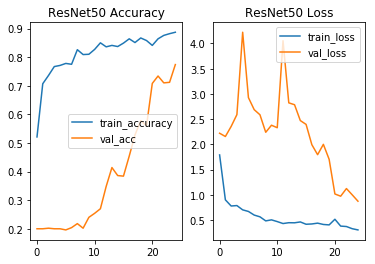

In [0]:
#plot acc
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
plt.subplot(1,2,1)
plt.plot(train_acc,label="train_accuracy")
plt.plot(val_acc,label="val_acc")
plt.legend()
plt.title('ResNet50 Accuracy')

#plot loss
train_loss=history.history['loss']
val_loss=history.history['val_loss']
plt.subplot(1,2,2)
plt.plot(train_loss,label="train_loss")
plt.plot(val_loss,label="val_loss")
plt.legend()
plt.title('ResNet50 Loss')
plt.show()

In [0]:
#-------------------------------------------------------------------

In [0]:
#load mobile net v2 model
conv_base2 = MobileNetV2(weights='imagenet',include_top=False,input_shape=(TARGET_SHAPE, TARGET_SHAPE, 3))

Instructions for updating:
Colocations handled automatically by placer.
9412608/9406464 [==============================] - 0s 0us/step


In [0]:
#define model
model2 = Sequential()
model2.add(conv_base2)
model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(32, activation=tf.nn.relu))
#model2.add(Dropout(0.5))
model2.add(Dense(32, activation=tf.nn.relu))
model2.add(Dense(3, activation='softmax'))

model2.summary()
conv_base2.trainable=False

model2.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 62720)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2007072   
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total para

In [0]:
EPOCHS=10
history = model2.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/10
405/405 [==============================] - 49s 121ms/step - loss: 0.8991 - acc: 0.5671 - val_loss: 0.5528 - val_acc: 0.8098
Epoch 2/10
405/405 [==============================] - 49s 120ms/step - loss: 0.7878 - acc: 0.6128 - val_loss: 0.4987 - val_acc: 0.8161
Epoch 3/10
405/405 [==============================] - 49s 121ms/step - loss: 0.7454 - acc: 0.6229 - val_loss: 0.5630 - val_acc: 0.7804
Epoch 4/10
405/405 [==============================] - 49s 120ms/step - loss: 0.7052 - acc: 0.6656 - val_loss: 0.5543 - val_acc: 0.8067
Epoch 5/10
405/405 [==============================] - 49s 121ms/step - loss: 0.6805 - acc: 0.6835 - val_loss: 0.5293 - val_acc: 0.8158
Epoch 6/10
405/405 [==============================] - 48s 117ms/step - loss: 0.6638 - acc: 0.6901 - val_loss: 0.5386 - val_acc: 0.8207
Epoch 7/10
405/405 [==============================] - 49s 121ms/step - loss: 0.6643 - acc: 0.6953 - val_loss: 0.5184 - val_acc: 0.8193
Epoch 8/10
405/405 [==============================] - 4

In [0]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

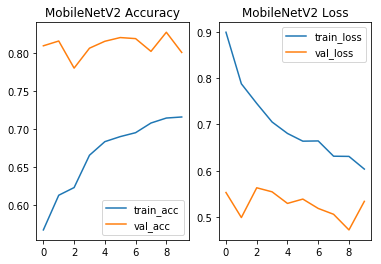

In [0]:
#plot acc
train_acc=history.history['acc']
val_acc=history.history['val_acc']
plt.subplot(1,2,1)
plt.plot(train_acc,label="train_acc")
plt.plot(val_acc,label="val_acc")
plt.legend()
plt.title('MobileNetV2 Accuracy')

#plot loss
train_loss=history.history['loss']
val_loss=history.history['val_loss']
plt.subplot(1,2,2)
plt.plot(train_loss,label="train_loss")
plt.plot(val_loss,label="val_loss")
plt.legend()
plt.title('MobileNetV2 Loss')
plt.show()

In [0]:
#save model weights
local_name = 'my_model_weights.h5'
model2.save_weights(local_name)

In [0]:
def upload_to_folder(folder_id, file_name_local, file_name_in_folder):
    file_metadata = {'title': file_name_in_folder, "parents": [{"id": folder_id, "kind": "drive#childList"}]}
    folder = drive.CreateFile(file_metadata)
    folder.SetContentFile(file_name_local) #The contents of the file
    folder.Upload()

In [0]:
#save model weights
upload_to_folder(model_folder_id, local_name, local_name)

In [0]:
#save model
local_name = 'my_model.h5'
model2.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
#del model2  # deletes the existing model

In [0]:
# returns a compiled model
# identical to the previous one
model2 = load_model(local_name)

AttributeError: ignored